In [1]:
import io
import pandas as pd
import requests
import matplotlib.pyplot as plt
import zipfile
%matplotlib inline

### Country Populations

https://data.worldbank.org/indicator/SP.POP.TOTL

In [2]:
r = requests.get("http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv", stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
f = z.open('API_SP.POP.TOTL_DS2_en_csv_v2_821007.csv')
pop = pd.read_csv(f, header=2)

In [3]:
pop = pop.rename(columns={'Country Name': 'country', 'Country Code': 'ccode', '2018': 'pop_count'})
pop['country'] = pop['country'].str.upper()
pop = pop.loc[:,['country', 'ccode', 'pop_count']]
pop.sample(5)

,country,ccode,pop_count
253,BRITISH VIRGIN ISLANDS,VGB,29802.0
195,PACIFIC ISLAND SMALL STATES,PSS,2457367.0
114,ITALY,ITA,60431283.0
53,GERMANY,DEU,82927922.0
52,CZECH REPUBLIC,CZE,10625695.0


### COVID-19 Case Count

https://experience.arcgis.com/experience/685d0ace521648f8a5beeeee1b9125cd

In [4]:
raw = requests.get("https://services.arcgis.com/5T5nSi527N4F7luB/arcgis/rest/services/COVID_19_HistoricCasesByCountry(pt)View/FeatureServer/0/query?f=json&where=1%3D1&returnGeometry=false&spatialRel=esriSpatialRelIntersects&outFields=OBJECTID%2Ccum_conf%2CDateOfDataEntry%2CADM0_NAME&orderByFields=DateOfDataEntry%20asc&resultOffset=0&resultRecordCount=2000&cacheHint=true")

In [5]:
raw.json()['features'][:3]

[{'attributes': {'OBJECTID': 908,
   'cum_conf': 1,
   'DateOfDataEntry': 1579651200000,
   'ADM0_NAME': 'JAPAN'}},
 {'attributes': {'OBJECTID': 1370,
   'cum_conf': 1,
   'DateOfDataEntry': 1579651200000,
   'ADM0_NAME': 'REPUBLIC OF KOREA'}},
 {'attributes': {'OBJECTID': 1736,
   'cum_conf': 4,
   'DateOfDataEntry': 1579651200000,
   'ADM0_NAME': 'THAILAND'}}]

In [6]:
data = pd.json_normalize(raw.json(), record_path='features')
data = data.rename(columns={'attributes.OBJECTID':'id', 'attributes.ADM0_NAME': 'country',
                            'attributes.cum_conf':'cumsum', 'attributes.DateOfDataEntry':'unixtime'})
data['date'] = pd.to_datetime(data['unixtime'], origin='unix', unit='ms')
data.sample(5)

,id,cumsum,unixtime,country,date
295,1957,12,1581033600000,VIET NAM,2020-02-07
330,721,3,1581206400000,INDIA,2020-02-09
1812,796,696,1583798400000,International conveyance (Diamond Princess),2020-03-10
654,888,4,1582243200000,ITALY,2020-02-21
1207,45,1,1583280000000,ARGENTINA,2020-03-04


### Merged data

In [7]:
keys = ['BELGIUM', 'NETHERLANDS', 'LUXEMBOURG', 'FRANCE', 'ITALY', 'GERMANY', 'CHINA']

In [8]:
merged = pop.merge(data, on='country', how='right')
merged['normalized'] = 1e5*merged['cumsum']/merged['pop_count']
merged.sample(5)

,country,ccode,pop_count,id,cumsum,unixtime,date,normalized
1575,SAN MARINO,SMR,33785.0,1501,24,1583539200000,2020-03-07,71.037443
1837,VIET NAM,NaN,NaN,1967,16,1581897600000,2020-02-17,NaN
1902,EGYPT,NaN,NaN,475,1,1582243200000,2020-02-21,NaN
202,BELGIUM,BEL,11422068.0,209,267,1583884800000,2020-03-11,2.337580
462,DENMARK,DNK,5797446.0,437,3,1583020800000,2020-03-01,0.051747


In [9]:
data.to_csv('covid19_{:%Y%m%d}.csv'.format(pd.Timestamp.now()))

In [10]:
cross = merged.pivot_table(index='date', columns='country', values='cumsum')
cross.tail(5)[keys]

country,BELGIUM,NETHERLANDS,LUXEMBOURG,FRANCE,ITALY,GERMANY,CHINA
date,,,,,,,
2020-03-07,169.0,128.0,2.0,613.0,4636.0,639.0,80813.0
2020-03-08,169.0,188.0,2.0,939.0,5883.0,847.0,80859.0
2020-03-09,200.0,265.0,2.0,1116.0,7375.0,1112.0,80904.0
2020-03-10,239.0,321.0,5.0,1402.0,9172.0,1139.0,80924.0
2020-03-11,267.0,382.0,5.0,1774.0,10149.0,1296.0,80955.0


In [11]:
ncross = merged.pivot_table(index='date', columns='country', values='normalized')
ncross.tail(5)[keys]

country,BELGIUM,NETHERLANDS,LUXEMBOURG,FRANCE,ITALY,GERMANY,CHINA
date,,,,,,,
2020-03-07,1.479592,0.742846,0.329095,0.915100,7.671523,0.770549,5.802489
2020-03-08,1.479592,1.091056,0.329095,1.401759,9.735024,1.021369,5.805792
2020-03-09,1.750996,1.537924,0.329095,1.665989,12.203944,1.340924,5.809023
2020-03-10,2.092441,1.862920,0.822736,2.092936,15.177570,1.373482,5.810459
2020-03-11,2.337580,2.216932,0.822736,2.648265,16.794282,1.562803,5.812684


### Trends

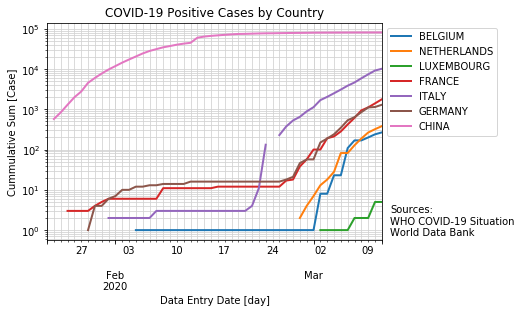

In [12]:
axe = cross[keys].plot(logy=True, linewidth=2)
axe.set_title("COVID-19 Positive Cases by Country")
axe.set_xlabel("Data Entry Date [day]")
axe.set_ylabel("Cummulative Sum [Case]")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")

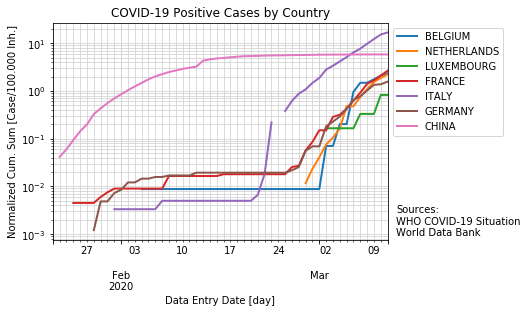

In [13]:
axe = ncross[keys].plot(logy=True, linewidth=2)
axe.set_title("COVID-19 Positive Cases by Country")
axe.set_xlabel("Data Entry Date [day]")
axe.set_ylabel("Normalized Cum. Sum [Case/100.000 Inh.]")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")

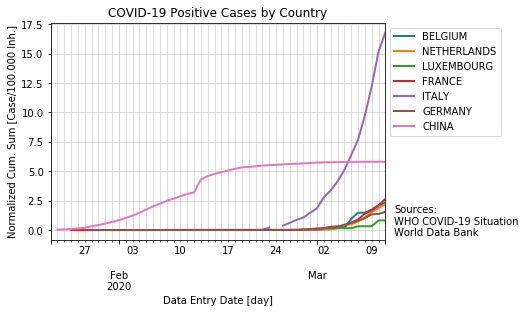

In [21]:
axe = ncross.loc[:,keys].plot(linewidth=2)
axe.set_title("COVID-19 Positive Cases by Country")
axe.set_xlabel("Data Entry Date [day]")
axe.set_ylabel("Normalized Cum. Sum [Case/100.000 Inh.]")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")

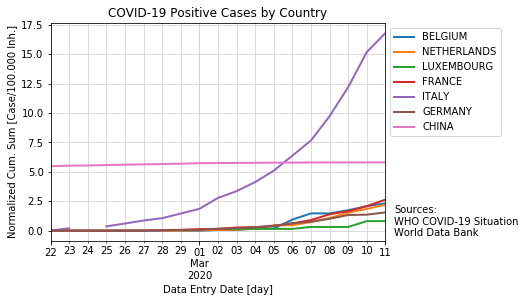

In [20]:
axe = ncross.loc['2020-02-22':,keys].plot(linewidth=2)
axe.set_title("COVID-19 Positive Cases by Country")
axe.set_xlabel("Data Entry Date [day]")
axe.set_ylabel("Normalized Cum. Sum [Case/100.000 Inh.]")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")

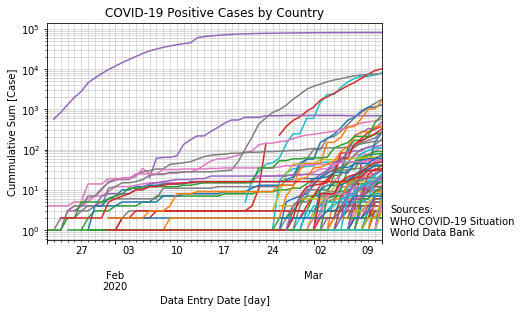

In [15]:
axe = cross.plot(logy=True)
axe.set_title("COVID-19 Positive Cases by Country")
axe.set_xlabel("Data Entry Date [day]")
axe.set_ylabel("Cummulative Sum [Case]")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")
axe.legend().remove()

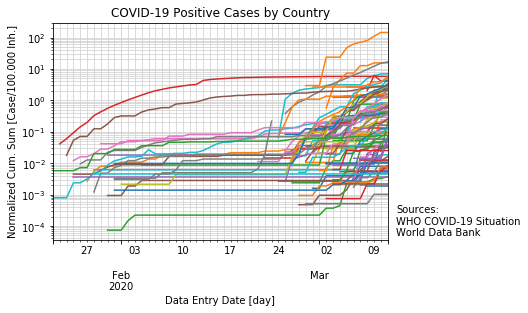

In [16]:
axe = ncross.plot(logy=True)
axe.set_title("COVID-19 Positive Cases by Country")
axe.set_xlabel("Data Entry Date [day]")
axe.set_ylabel("Normalized Cum. Sum [Case/100.000 Inh.]")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")
axe.legend().remove()

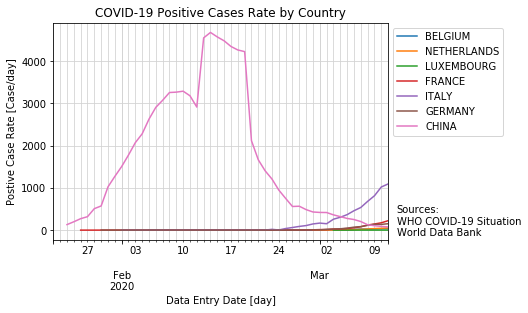

In [17]:
axe = cross.rolling(7, min_periods=1, center=False).mean().diff()[keys].plot()
axe.set_title("COVID-19 Positive Cases Rate by Country")
axe.set_xlabel("Data Entry Date [day]")
axe.set_ylabel("Postive Case Rate [Case/day]")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")

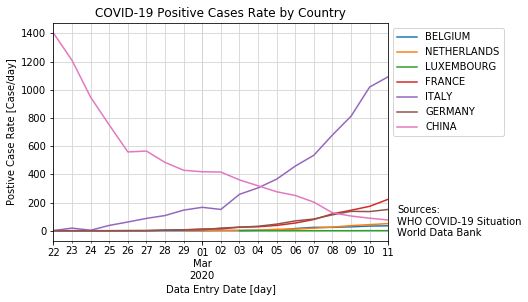

In [19]:
axe = cross.rolling(7, min_periods=1, center=False).mean().diff().loc['2020-02-22':,keys].plot()
axe.set_title("COVID-19 Positive Cases Rate by Country")
axe.set_xlabel("Data Entry Date [day]")
axe.set_ylabel("Postive Case Rate [Case/day]")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")

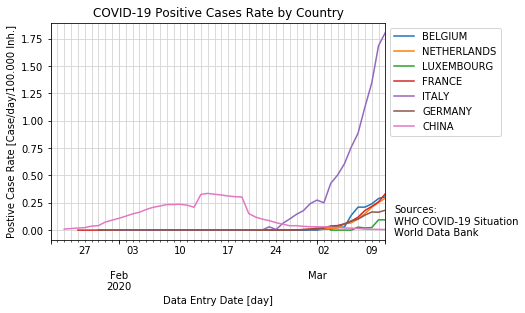

In [18]:
axe = ncross.rolling(7, min_periods=1, center=False).mean().diff()[keys].plot()
axe.set_title("COVID-19 Positive Cases Rate by Country")
axe.set_xlabel("Data Entry Date [day]")
axe.set_ylabel("Postive Case Rate [Case/day/100.000 Inh.]")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")